In [15]:
import pandas as pd
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as keras_image # 이름 충돌 방지
from tensorflow.keras.models import Model
from PIL import Image 
from pathlib import Path
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm 
import time

In [43]:
# 1. 시작일과 종료일 지정
start_date = '2011-03-01'
end_date = '2025-02-01' # date_range는 end_date를 포함합니다.

# 2. pd.date_range()를 사용하여 날짜 시퀀스 생성 (freq='D'는 기본값이지만 명시)
date_sequence = pd.date_range(start=start_date, end=end_date, freq='D')

# 3. 생성된 날짜 시퀀스를 사용하여 데이터프레임 생성
date_1 = pd.DataFrame(date_sequence, columns=['Date'])
date_1['Date'] = date_1['Date'].dt.strftime('%Y-%m-%d')
date_2 = pd.DataFrame(date_sequence, columns=['Date'])
date_2['Date'] = date_2['Date'].dt.strftime('%Y-%m-%d')
date_3= pd.DataFrame(date_sequence, columns=['Date'])
date_3['Date'] = date_3['Date'].dt.strftime('%Y-%m-%d')


In [44]:
values_index  = ['평균 수온(℃)',	'최고 수온(℃)',	'최저 수온(℃)',	'중앙 수온(℃)']

In [45]:
sea_1 = pd.read_excel('원본데이터\\2011_2-2025_2.xlsx')
sea_1 = sea_1.drop(columns='표준편차(℃)')
삼척_pivot = pd.pivot_table(sea_1,
                              index = (['관측소', '관측일']),
                              columns='수층',
                              values=values_index)

new_columns = []
for val_col, layer_col in 삼척_pivot.columns:
    # 실제 데이터의 '수층' 값 (예: '표층', '저층')을 확인하세요.
    if layer_col == '표층':
        prefix = '표층_'
    elif layer_col == '저층':
        prefix = '저층_'
    else:
        prefix = layer_col + '_' # 다른 수층 이름이 있을 경우 대비

    new_columns.append(prefix + val_col)

삼척_pivot.columns = new_columns
삼척_df = 삼척_pivot.reset_index()
삼척_df = date_1.merge(삼척_df,how='left',left_on='Date',right_on='관측일')

In [46]:
sea_2 = pd.read_csv('원본데이터\강릉_데이터.csv',encoding='cp949')
sea_2 = sea_2.drop(columns='표준편차(℃)')
강릉_pivot = pd.pivot_table(sea_2,
                              index = (['관측소', '관측일']),
                              columns='수층',
                              values=values_index)

new_columns = []
for val_col, layer_col in 강릉_pivot.columns:
    # 실제 데이터의 '수층' 값 (예: '표층', '저층')을 확인하세요.
    if layer_col == '표층':
        prefix = '표층_'
    elif layer_col == '저층':
        prefix = '저층_'
    else:
        prefix = layer_col + '_' # 다른 수층 이름이 있을 경우 대비

    new_columns.append(prefix + val_col)

강릉_pivot.columns = new_columns
강릉_df = 강릉_pivot.reset_index()
강릉_df = date_1.merge(강릉_df,how='left',left_on='Date',right_on='관측일')

In [47]:
cols_to_fill = ['관측일', '저층_중앙 수온(℃)', '중층_중앙 수온(℃)', '표층_중앙 수온(℃)',
       '저층_최고 수온(℃)', '중층_최고 수온(℃)', '표층_최고 수온(℃)', '저층_최저 수온(℃)',
       '중층_최저 수온(℃)', '표층_최저 수온(℃)', '저층_평균 수온(℃)', '중층_평균 수온(℃)',
       '표층_평균 수온(℃)']

삼척_df[cols_to_fill] = 삼척_df[cols_to_fill].combine_first(강릉_df[cols_to_fill])

In [48]:
삼척_df['관측소'] = 삼척_df['관측소'].fillna('삼척(bsc87)')
삼척_df = 삼척_df.drop(columns='관측일')

In [49]:
삼척_df['Date']=pd.to_datetime(삼척_df['Date'])

In [50]:

삼척_df = 삼척_df.set_index('Date')
numeric_cols = 삼척_df.select_dtypes(include=np.number).columns

# 숫자형 열에 대해서만 보간 수행
삼척_df[numeric_cols] = 삼척_df[numeric_cols].interpolate(method='time')

In [1]:
weather_data = pd.read_csv('원본데이터\동해날씨_20110201~20250201_통합본.csv')


NameError: name 'pd' is not defined

In [52]:
null_col=weather_data.isnull().sum()
null_col = null_col[null_col>300].index
null_col

Index(['mi10MaxRn', 'mi10MaxRnHrmt', 'hr1MaxRn', 'hr1MaxRnHrmt', 'sumRnDur',
       'sumRn', 'hr1MaxIcsrHrmt', 'hr1MaxIcsr', 'sumGsr', 'ddMefs',
       'ddMefsHrmt', 'ddMes', 'ddMesHrmt', 'sumDpthFhsc', 'avgTca', 'avgLmac',
       'avgCm5Te', 'avgCm10Te', 'avgCm20Te', 'avgCm30Te', 'avgM05Te',
       'avgM10Te', 'avgM15Te', 'avgM30Te', 'avgM50Te', 'sumLrgEv', 'sumSmlEv',
       'n99Rn', 'iscs', 'sumFogDur'],
      dtype='object')

In [53]:
weather_data = weather_data.drop(columns=null_col)

In [54]:
weather_data['tm']=pd.to_datetime(weather_data['tm'])
weather_data = weather_data.set_index('tm')
numeric_cols = weather_data.select_dtypes(include=np.number).columns

# 숫자형 열에 대해서만 보간 수행
weather_data[numeric_cols] = weather_data[numeric_cols].interpolate(method='time')
weather_data= weather_data.reset_index()


In [55]:
weather_data

,tm,stnId,stnNm,avgTa,minTa,minTaHrmt,maxTa,maxTaHrmt,maxInsWs,maxInsWsWd,...,avgPa,maxPs,maxPsHrmt,minPs,minPsHrmt,avgPs,ssDur,sumSsHr,avgTs,minTg
0,2011-02-01,106,동해,3.0,-0.5,617.0,7.3,1337,12.2,230.0,...,1016.6,1023.0,1057,1019.2,21,1021.5,10.3,9.6,0.6,-5.6
1,2011-02-02,106,동해,4.3,-0.3,101.0,8.9,1135,5.4,180.0,...,1015.5,1021.5,0,1019.0,1431,1020.4,10.4,7.8,1.5,-5.2
2,2011-02-03,106,동해,5.7,2.2,455.0,10.2,1225,10.0,230.0,...,1014.7,1021.1,858,1017.8,1503,1019.6,10.4,8.6,0.8,-5.4
3,2011-02-04,106,동해,5.5,1.6,304.0,10.0,1612,8.5,290.0,...,1012.4,1019.3,136,1014.7,1546,1017.3,10.4,6.0,1.3,-5.6
4,2011-02-05,106,동해,3.0,-0.3,2114.0,5.7,1325,8.5,20.0,...,1014.9,1022.8,1039,1017.1,0,1019.9,10.5,9.1,1.9,-5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,2025-01-28,106,동해,-0.4,-1.7,722.0,1.8,1259,27.2,270.0,...,1005.0,1014.2,2347,1005.5,1247,1010.1,10.2,8.8,-0.4,-3.7
5111,2025-01-29,106,동해,-1.3,-3.0,323.0,2.5,1407,18.0,270.0,...,1013.7,1022.8,2350,1013.8,32,1018.8,10.2,9.4,-1.3,-5.9
5112,2025-01-30,106,동해,1.3,-3.4,105.0,5.6,1508,15.7,320.0,...,1019.5,1026.9,2205,1022.7,2,1024.6,10.3,9.3,-0.4,-6.5
5113,2025-01-31,106,동해,3.3,-1.2,536.0,7.2,1223,5.1,340.0,...,1020.6,1027.7,934,1024.2,1631,1025.8,10.3,1.0,1.6,-4.7


In [56]:
Total_data = 삼척_df.merge(weather_data,how ='left',left_on='Date',right_on='tm')
Total_data = Total_data.dropna(axis=0)
Total_data = Total_data.drop(columns=['stnId','stnNm'])
Total_data = Total_data.set_index('tm')
# Total_data.to_csv('Total_data.csv',index=False,encoding='utf-8-sig')

In [57]:
Total_data_copy = Total_data.copy()

In [58]:
file_path = 'cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_1745964964997.nc'
variable_name = 'CHL'
png_output_dir = 'daily_chl_maps_2011_2025'  
output_csv_file = 'Total_Conv_df.csv'
start_date = '2011-03-01'
end_date = '2025-02-01'

IMG_SIZE = 224
os.makedirs(png_output_dir, exist_ok=True)

base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))
# 모델 자체를 특징 추출기로 사용
model = Model(inputs=base_model.input, outputs=base_model.output)

print(f"ResNet50 model loaded. Feature vector size: {model .output_shape[1]}")

ResNet50 model loaded. Feature vector size: 2048


In [59]:
# # 이미지 추출
# with xr.open_dataset(file_path) as ds:
#     chl_data_filtered = ds[variable_name].sel(time=slice(start_date, end_date))
#     for current_time in tqdm(chl_data_filtered['time'], desc="Processing Days"):
#         date_str = pd.to_datetime(current_time.values).strftime('%Y-%m-%d')
#         if (date_str == "2015-01-01" )|(date_str == "2020-01-01" ) :
#             time.sleep(60)
#         daily_chl_xr = chl_data_filtered.sel(time=current_time)
#         daily_chl_np = daily_chl_xr.values
#         fig = plt.figure(figsize=(8, 6)) # 이미지 크기 조절 가능
#         ax = plt.axes(projection=ccrs.PlateCarree()) # 지도 투영법 설정
#         # 원본 데이터(daily_chl_xr)를 사용하여 시각화
#         daily_chl_xr.plot.pcolormesh(
#             ax=ax,
#             transform=ccrs.PlateCarree(),
#             cmap='viridis', # 컬러맵
#             cbar_kwargs={'label': f'{variable_name} Concentration'} # 컬러바 레이블
#         )
#         ax.coastlines() # 해안선 추가
#         ax.set_title(f'{variable_name} on {date_str}') # 제목 설정
#         # PNG 파일 저장
#         output_png_filename = os.path.join(png_output_dir, f'{variable_name}_{date_str}.png')
#         try:
#             plt.savefig(output_png_filename, dpi=100, bbox_inches='tight') # 해상도(dpi) 조절 가능
#         except Exception as img_e:
#             print(f"  Warning: Could not save image for {date_str} - {img_e}")
#         plt.close(fig)

In [60]:
#CNN특징추출
# n=0
# with xr.open_dataset(file_path) as ds:
#     chl_data_filtered = ds[variable_name].sel(time=slice(start_date, end_date))
#     for current_time in tqdm(chl_data_filtered['time'], desc="Processing Days"):
#         date_str = pd.to_datetime(current_time.values).strftime('%Y-%m-%d')
#         daily_chl_xr = chl_data_filtered.sel(time=current_time)
#         daily_chl_np = daily_chl_xr.values
        
#         # b. 결측치(NaN) 처리 (예: 0으로 채우기)
#         daily_chl_np_filled = np.nan_to_num(daily_chl_np, nan=0.0)
#         # d. 채널 차원 추가 (H, W) -> (H, W, 1)
#         normalized_data_ch = np.expand_dims(daily_chl_np_filled, axis=-1)
#         # e. 이미지 리사이즈 (H, W, 1) -> (IMG_SIZE, IMG_SIZE, 1)
#         #    tf.image.resize는 TensorFlow 텐서를 입력으로 받음
#         resized_data = tf.image.resize(tf.constant(normalized_data_ch, dtype=tf.float32),
#                                         (IMG_SIZE, IMG_SIZE),
#                                         method=tf.image.ResizeMethod.BILINEAR) # 보간법 지정
#         # f. 채널 복제 (IMG_SIZE, IMG_SIZE, 1) -> (IMG_SIZE, IMG_SIZE, 3)
#         data_3channel = tf.repeat(resized_data, 3, axis=-1)
#         # g. ResNet50 전용 전처리 함수 적용
#         #    preprocess_input은 NumPy 배열 또는 TF 텐서를 받을 수 있음
#         preprocessed_data = preprocess_input(data_3channel.numpy()) # NumPy로 변환 후 적용
#         # h. 배치 차원 추가 (IMG_SIZE, IMG_SIZE, 3) -> (1, IMG_SIZE, IMG_SIZE, 3)
#         resnet_input = np.expand_dims(preprocessed_data, axis=0)

#         # # --- 4.2 ResNet50 피처 추출 ---
#         features = model.predict(resnet_input, verbose=0)
#         feature_vector = features[0]
#         feature_columns = [f'cnn_feat_{i}' for i in range(len(feature_vector))]
#         df_cnn_features = pd.DataFrame([feature_vector] ,columns=feature_columns)
#         date = str(date_str)
#         date_info = pd.DataFrame({'Date':[date_str]})
#         total_df = pd.concat([date_info,df_cnn_features],axis=1)
#         if n==0:
#             df_cnn = total_df
#         else:
#             df_cnn = pd.concat([df_cnn,total_df],axis=0)
#         n+=1

In [61]:
df_cnn.reset_index(inplace=True,drop=True)

In [62]:
df_cnn

,Date,cnn_feat_0,cnn_feat_1,cnn_feat_2,cnn_feat_3,cnn_feat_4,cnn_feat_5,cnn_feat_6,cnn_feat_7,cnn_feat_8,...,cnn_feat_2038,cnn_feat_2039,cnn_feat_2040,cnn_feat_2041,cnn_feat_2042,cnn_feat_2043,cnn_feat_2044,cnn_feat_2045,cnn_feat_2046,cnn_feat_2047
0,2011-03-01,0.000000,0.0,0.0,0.0,0.013483,0.0,0.000000,0.022381,0.0,...,0.000000,0.0,0.441812,0.0,0.0,0.0,0.0,0.011907,0.002775,0.0
1,2011-03-02,0.000000,0.0,0.0,0.0,0.012951,0.0,0.000000,0.022287,0.0,...,0.000000,0.0,0.442349,0.0,0.0,0.0,0.0,0.011927,0.002806,0.0
2,2011-03-03,0.000000,0.0,0.0,0.0,0.015704,0.0,0.000000,0.034167,0.0,...,0.000000,0.0,0.530445,0.0,0.0,0.0,0.0,0.063595,0.017758,0.0
3,2011-03-04,0.000000,0.0,0.0,0.0,0.012965,0.0,0.000000,0.039949,0.0,...,0.000000,0.0,0.448757,0.0,0.0,0.0,0.0,0.034620,0.011156,0.0
4,2011-03-05,0.000000,0.0,0.0,0.0,0.007093,0.0,0.000000,0.032346,0.0,...,0.000000,0.0,0.448075,0.0,0.0,0.0,0.0,0.034897,0.010909,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,2025-01-28,0.000000,0.0,0.0,0.0,0.045301,0.0,0.013927,0.045418,0.0,...,0.010029,0.0,0.671787,0.0,0.0,0.0,0.0,0.196714,0.126501,0.0
5083,2025-01-29,0.006098,0.0,0.0,0.0,0.042127,0.0,0.000000,0.012880,0.0,...,0.002754,0.0,0.907064,0.0,0.0,0.0,0.0,0.170665,0.138065,0.0
5084,2025-01-30,0.076320,0.0,0.0,0.0,0.064886,0.0,0.038533,0.019335,0.0,...,0.043041,0.0,0.919387,0.0,0.0,0.0,0.0,0.153779,0.117201,0.0
5085,2025-01-31,0.076111,0.0,0.0,0.0,0.065478,0.0,0.035264,0.020170,0.0,...,0.039660,0.0,0.923541,0.0,0.0,0.0,0.0,0.153274,0.116411,0.0


In [63]:
sample_df=df_cnn[:2500]

In [64]:
df_cnn.to_csv('Image_cnn_df.csv',encoding='utf-8-sig',index=False)

In [65]:
Total_data_copy =Total_data_copy.reset_index()
Total_data_copy ['tm'] = Total_data_copy ['tm'].dt.strftime('%Y-%m-%d')

In [66]:
ToTal_image_df = Total_data_copy.merge(df_cnn,how='left',left_on='tm',right_on='Date')

In [69]:
ToTal_image_df=ToTal_image_df.drop(columns=[ 'tm'])
ToTal_image_df=ToTal_image_df.set_index('Date')

In [70]:
ToTal_image_df.to_csv('Ocean_Environment_Data.csv',encoding='utf-8-sig')

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
import pandas as pd
#   

In [73]:
import sklearn

In [74]:
dir(sklearn.preprocessing)

['Binarizer',
 'FunctionTransformer',
 'KBinsDiscretizer',
 'KernelCenterer',
 'LabelBinarizer',
 'LabelEncoder',
 'MaxAbsScaler',
 'MinMaxScaler',
 'MultiLabelBinarizer',
 'Normalizer',
 'OneHotEncoder',
 'OrdinalEncoder',
 'PolynomialFeatures',
 'PowerTransformer',
 'QuantileTransformer',
 'RobustScaler',
 'SplineTransformer',
 'StandardScaler',
 'TargetEncoder',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_csr_polynomial_expansion',
 '_data',
 '_discretization',
 '_encoders',
 '_function_transformer',
 '_label',
 '_polynomial',
 '_target_encoder',
 '_target_encoder_fast',
 'add_dummy_feature',
 'binarize',
 'label_binarize',
 'maxabs_scale',
 'minmax_scale',
 'normalize',
 'power_transform',
 'quantile_transform',
 'robust_scale',
 'scale']

In [74]:
ToTal_image_df=ToTal_image_df.drop(columns='관측소')

In [104]:
scale_column=ToTal_image_df.columns[:41]

In [108]:
ToTal_image_df.drop(columns=['Target'],inplace=True)

In [167]:
data = pd.read_csv('Ocean_Environment_Data.csv')

In [168]:
data = data.drop(columns='관측소')

In [169]:
data=data.set_index('Date')

In [131]:
col=data.columns[:]

In [40]:
data[col]

,cnn_feat_0,cnn_feat_1,cnn_feat_2,cnn_feat_3,cnn_feat_4,cnn_feat_5,cnn_feat_6,cnn_feat_7,cnn_feat_8,cnn_feat_9,...,cnn_feat_2038,cnn_feat_2039,cnn_feat_2040,cnn_feat_2041,cnn_feat_2042,cnn_feat_2043,cnn_feat_2044,cnn_feat_2045,cnn_feat_2046,cnn_feat_2047
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-01,0.000000,0.0,0.0,0.0,0.013483,0.0,0.000000,0.022381,0.0,0.0,...,0.000000,0.0,0.441812,0.0,0.0,0.0,0.0,0.011907,0.002775,0.0
2011-03-02,0.000000,0.0,0.0,0.0,0.012951,0.0,0.000000,0.022287,0.0,0.0,...,0.000000,0.0,0.442350,0.0,0.0,0.0,0.0,0.011927,0.002806,0.0
2011-03-03,0.000000,0.0,0.0,0.0,0.015704,0.0,0.000000,0.034167,0.0,0.0,...,0.000000,0.0,0.530445,0.0,0.0,0.0,0.0,0.063595,0.017758,0.0
2011-03-04,0.000000,0.0,0.0,0.0,0.012965,0.0,0.000000,0.039949,0.0,0.0,...,0.000000,0.0,0.448757,0.0,0.0,0.0,0.0,0.034620,0.011156,0.0
2011-03-05,0.000000,0.0,0.0,0.0,0.007093,0.0,0.000000,0.032346,0.0,0.0,...,0.000000,0.0,0.448075,0.0,0.0,0.0,0.0,0.034897,0.010909,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,0.000000,0.0,0.0,0.0,0.045301,0.0,0.013927,0.045418,0.0,0.0,...,0.010029,0.0,0.671787,0.0,0.0,0.0,0.0,0.196714,0.126501,0.0
2025-01-29,0.006098,0.0,0.0,0.0,0.042127,0.0,0.000000,0.012880,0.0,0.0,...,0.002754,0.0,0.907064,0.0,0.0,0.0,0.0,0.170665,0.138065,0.0
2025-01-30,0.076320,0.0,0.0,0.0,0.064886,0.0,0.038533,0.019335,0.0,0.0,...,0.043041,0.0,0.919387,0.0,0.0,0.0,0.0,0.153779,0.117201,0.0


In [148]:
data_s = data.copy()

In [149]:
## 하이   ### 여기에요욤ㄹㅇ료묜ㅇ료냐래ㅛㄴㅁㄹㅇ
scaler = MinMaxScaler()
data_s[col] = scaler.fit_transform(data_s[col])

In [150]:
inertia = []
for n_clusters in range(1,30):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_s)
    inertia.append(kmeans.inertia_)

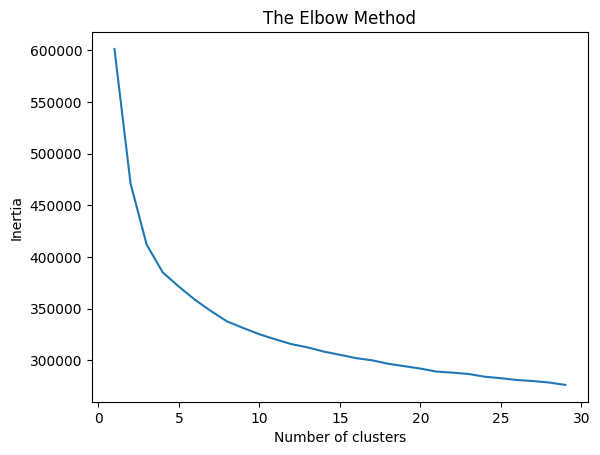

In [151]:
plt.plot(range(1, 30), inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [107]:
range_n_clusters = list(range(2, 10))

In [53]:
from sklearn.metrics import silhouette_score

For n_clusters = 2, the average silhouette_score is : 0.374
For n_clusters = 3, the average silhouette_score is : 0.259
For n_clusters = 4, the average silhouette_score is : 0.254
For n_clusters = 5, the average silhouette_score is : 0.249
For n_clusters = 6, the average silhouette_score is : 0.214
For n_clusters = 7, the average silhouette_score is : 0.203
For n_clusters = 8, the average silhouette_score is : 0.214
For n_clusters = 9, the average silhouette_score is : 0.215


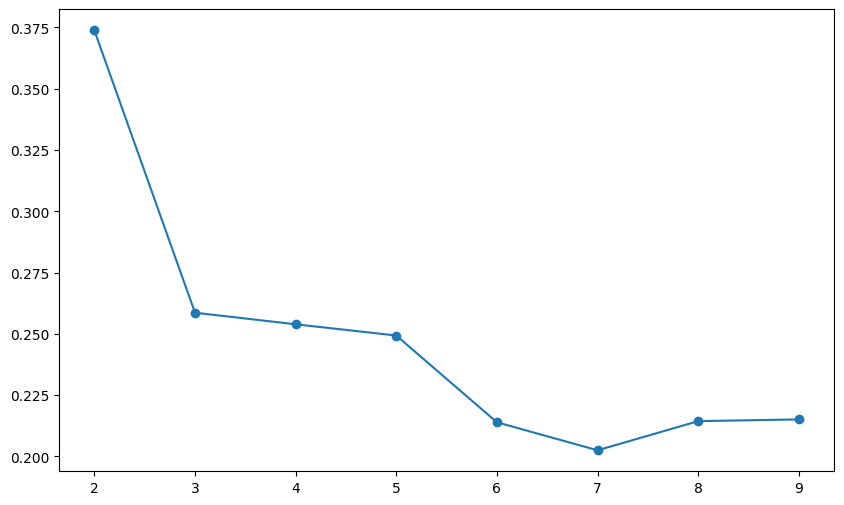

In [ ]:
silhouette_avg_scores = []
#실루엣 K=3
# 각 클러스터 수(n_clusters)에 대해 KMeans 알고리즘 실행
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0) # 클러스터 수를 n_clusters로 설정하여 KMeans 객체를 생성
    cluster_labels = clusterer.fit_predict(data_s) # 데이터 X에 대해 클러스터링 수행, 각 데이터 포인트가 속한 클러스터 레이블 반환

    # 실루엣 스코어(Silhouette Score) 계산:
    silhouette_avg = silhouette_score(data_s, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
data['Target'] = kmeans.fit_predict(data_s)

In [164]:
data.groupby('Target').count()

,저층_중앙 수온(℃),중층_중앙 수온(℃),표층_중앙 수온(℃),저층_최고 수온(℃),중층_최고 수온(℃),표층_최고 수온(℃),저층_최저 수온(℃),중층_최저 수온(℃),표층_최저 수온(℃),저층_평균 수온(℃),...,cnn_feat_2038,cnn_feat_2039,cnn_feat_2040,cnn_feat_2041,cnn_feat_2042,cnn_feat_2043,cnn_feat_2044,cnn_feat_2045,cnn_feat_2046,cnn_feat_2047
Target,,,,,,,,,,,,,,,,,,,,,
0,681,681,681,681,681,681,681,681,681,681,...,681,681,681,681,681,681,681,681,681,681
1,892,892,892,892,892,892,892,892,892,892,...,892,892,892,892,892,892,892,892,892,892
2,654,654,654,654,654,654,654,654,654,654,...,654,654,654,654,654,654,654,654,654,654
3,2344,2344,2344,2344,2344,2344,2344,2344,2344,2344,...,2344,2344,2344,2344,2344,2344,2344,2344,2344,2344
4,516,516,516,516,516,516,516,516,516,516,...,516,516,516,516,516,516,516,516,516,516


In [173]:
data.to_csv('Total_data_Fix.csv',encoding= 'utf-8-sig',index=True)

In [174]:
df = pd.read_csv('Total_data_Fix.csv')

In [175]:
df

,Date,저층_중앙 수온(℃),중층_중앙 수온(℃),표층_중앙 수온(℃),저층_최고 수온(℃),중층_최고 수온(℃),표층_최고 수온(℃),저층_최저 수온(℃),중층_최저 수온(℃),표층_최저 수온(℃),...,cnn_feat_2039,cnn_feat_2040,cnn_feat_2041,cnn_feat_2042,cnn_feat_2043,cnn_feat_2044,cnn_feat_2045,cnn_feat_2046,cnn_feat_2047,Target
0,2011-03-01,8.60,8.6,8.5,9.1,9.00,8.8,8.40,8.4,8.2,...,0.0,0.441812,0.0,0.0,0.0,0.0,0.011907,0.002775,0.0,3
1,2011-03-02,8.60,8.9,8.7,9.0,9.10,9.3,7.30,8.5,8.6,...,0.0,0.442350,0.0,0.0,0.0,0.0,0.011927,0.002806,0.0,3
2,2011-03-03,7.90,8.3,8.4,8.3,8.80,9.1,7.60,7.9,7.9,...,0.0,0.530445,0.0,0.0,0.0,0.0,0.063595,0.017758,0.0,3
3,2011-03-04,8.45,8.7,8.2,8.7,9.05,8.3,8.25,8.4,8.2,...,0.0,0.448757,0.0,0.0,0.0,0.0,0.034620,0.011156,0.0,3
4,2011-03-05,9.00,9.1,9.2,9.1,9.30,9.3,8.90,8.9,9.0,...,0.0,0.448075,0.0,0.0,0.0,0.0,0.034897,0.010909,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,2025-01-28,11.20,11.8,11.9,11.9,12.10,12.2,8.30,10.8,11.0,...,0.0,0.671787,0.0,0.0,0.0,0.0,0.196714,0.126501,0.0,2
5083,2025-01-29,11.00,11.1,11.3,11.5,11.50,11.6,10.60,11.0,11.0,...,0.0,0.907064,0.0,0.0,0.0,0.0,0.170665,0.138065,0.0,2
5084,2025-01-30,11.50,11.7,11.8,12.0,12.10,12.1,10.80,11.1,11.0,...,0.0,0.919387,0.0,0.0,0.0,0.0,0.153779,0.117201,0.0,2
5085,2025-01-31,11.90,11.9,12.0,12.1,12.10,12.1,10.10,11.3,11.9,...,0.0,0.923541,0.0,0.0,0.0,0.0,0.153274,0.116411,0.0,2
